# Homework for JLeague competition

## Setting up

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model

import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

# Path
input_path = "../input_data/"

# Figure Size
plt.rcParams["figure.figsize"] = (20.0, 10.0)

# Set Display Max Columns
pd.set_option("display.max_columns", 50)

# Set Display Max Rows
pd.set_option("display.max_rows", 200)

# Load datasets
train = pd.read_csv(input_path + "jleague/train.csv", sep=",", header=0, quotechar="\"", encoding='utf-8')
test = pd.read_csv(input_path + "jleague/test.csv", sep=",", header=0, quotechar="\"", encoding='utf-8')
condition = pd.read_csv(input_path + "jleague/condition.csv", sep=",", header=0, quotechar="\"", encoding='utf-8')
stadium = pd.read_csv(input_path + "jleague/stadium.csv", sep=",", header=0, quotechar="\"", encoding='utf-8')

## Merging datasets for feature engineering

In [2]:
# Train and Test, exclude y= 0
dat = pd.concat([train.query("y > 0"), test], axis=0)
dat["data"] = dat["y"].apply(lambda x: "Test" if np.isnan(x) else "Train")

# condition
dat = pd.merge(dat, condition, how="inner", on="id")

# stadium
dat = pd.merge(dat, stadium, how="inner", left_on="stadium", right_on="name")
dat.shape

(2033, 45)

## Feature engineering

In [3]:
# Original FE by sensei
# J1フラグ
dat["J1_flg"] = dat["stage"].apply(lambda x: 1 if x=="Ｊ１" else 0)

# 12月フラグ
dat["month"] = dat["gameday"].apply(lambda x: int(x.split("/")[0]))
dat["December_flg"] = dat["month"].apply(lambda x: 1 if x==12 else 0)

# ホームチームごとの平均観客動員数(y=0の試合を除く)
team_attract = dat[(dat["data"]=="Train") & (dat["y"] > 0)].groupby("home").agg({"y": "mean"}).reset_index(drop=False)
team_attract.columns = ["home", "attract_mean"]
dat = pd.merge(dat, team_attract, how="inner", on="home")

# TV放送数
dat["tv_N"] = dat["tv"].apply(lambda x: len(x.split("／")))

# NHKフラグ
dat["tv_NHK_flg"] = dat["tv"].apply(lambda x: 1 if "ＮＨＫ" in x else 0)

# capa
dat["capa_cate"] = dat["capa"].apply(lambda x: x // 10000)
dat["capa_cate"] = dat["capa_cate"].apply(lambda x: 5.5 if x == 7 else x)
dat["capa_cate"] = dat["capa_cate"].apply(lambda x: 7 if x == 6 else x)

In [4]:
# Added for V2 submission
# calculate capa %
capa_pct = dat[(dat["data"]=="Train") & (dat["y"] > 0)].assign(capa_pct=lambda x: x["y"]/x["capa"])
# home team and stadium mean capa %
home_capa_pct = capa_pct.groupby("home").agg(home_capa_pct=("capa_pct","mean")).reset_index()
away_capa_pct = capa_pct.groupby("away").agg(away_capa_pct=("capa_pct","mean")).reset_index()
stadium_capa_pct = capa_pct.groupby("stadium").agg(stadium_capa_pct=("capa_pct","mean")).reset_index()
dat = pd.merge(dat, home_capa_pct, how="left", on="home")
dat = pd.merge(dat, away_capa_pct, how="left", on="away")
dat = pd.merge(dat, stadium_capa_pct, how="left", on='stadium')
dat['stadium_capa_pct'] = dat['stadium_capa_pct'].fillna(stadium_capa_pct['stadium_capa_pct'].mean())
dat['team_capa_pct'] = (dat["home_capa_pct"] + dat["away_capa_pct"]) / 2
dat["team_capa_pct_y"] = dat['team_capa_pct'] * dat['capa']
dat['stadium_capa_pct_y'] = dat['stadium_capa_pct'] * dat['capa']

In [5]:
# For V3 submission
# getting all players
# setting player name columns
home_col = []
away_col = []
for n in range(1,12):
    home_col.append('home_'+f"{n:02d}")
    away_col.append('away_'+f"{n:02d}")

player_col = home_col + away_col

# unique player list from columns (train+test)
player = dat[player_col].stack().unique().tolist()
# adding list of players in single column
dat['home_players'] = tuple(dat[home_col].itertuples(index=False))
dat['away_players'] = tuple(dat[away_col].itertuples(index=False))
dat['players'] = tuple(dat[player_col].itertuples(index=False))
capa_pct['home_players'] = tuple(capa_pct[home_col].itertuples(index=False))
capa_pct['away_players'] = tuple(capa_pct[away_col].itertuples(index=False))
capa_pct['players'] = tuple(capa_pct[player_col].itertuples(index=False))

# compute player popularity
player_df = pd.DataFrame()
player_capa_pct = []
player_count = []
total_y = []
for name in player:
    played = capa_pct[ capa_pct['players'].apply(lambda x: name in x)]
    player_capa_pct.append(played['capa_pct'].mean())
    player_count.append(len(played['capa_pct']))
    total_y.append(played['y'].sum())
    
player_df['name'] = player
player_df['capa_pct'] = player_capa_pct
player_df['match_count'] = player_count
player_df['total_y'] = total_y
# fill in missing data with mean capa pct (players not in train)
player_df['capa_pct'] = player_df['capa_pct'].fillna(player_df['capa_pct'].mean())

player_df.head(3)

,name,capa_pct,match_count,total_y
0,林 卓人,0.640082,75,1243211.0
1,菅井 直樹,0.658546,58,924031.0
2,鎌田 次郎,0.654062,65,1045027.0


In [6]:
#find hot player?
player_df.sort_values(by='capa_pct',ascending=False).query('match_count >= 5').head(3)

,name,capa_pct,match_count,total_y
1146,ゴイコ カチャル,0.769855,10,272282.0
982,ニール,0.764991,5,116824.0
1139,フォルラン,0.762775,13,368923.0


In [7]:
# compute mean capa_pct for players of both teams, home, and away
match_players = dat.groupby("players").agg(player_match=("y","count")).reset_index()
mean_capa_pct = []
total_y = []

for match in match_players["players"]:
    members = player_df[ player_df["name"].apply(lambda x: x in match) ]
    mean_capa_pct.append(members["capa_pct"].mean())
    total_y.append(members["total_y"].sum())

match_players["mean_allplayer_capa_pct"] = mean_capa_pct
match_players["mean_allplayer_total_y"] = total_y

# home players
home_players = dat.groupby("home_players").agg(hometeam_match=("y","count")).reset_index()
mean_capa_pct = []
total_y = []

for match in home_players["home_players"]:
    members = player_df[ player_df["name"].apply(lambda x: x in match) ]
    mean_capa_pct.append(members["capa_pct"].mean())
    total_y.append(members["total_y"].sum())

home_players["mean_home_capa_pct"] = mean_capa_pct
home_players["mean_home_total_y"] = total_y

# away players
away_players = dat.groupby("away_players").agg(awayteam_match=("y","count")).reset_index()
mean_capa_pct = []
total_y = []

for match in away_players["away_players"]:
    members = player_df[ player_df["name"].apply(lambda x: x in match) ]
    mean_capa_pct.append(members["capa_pct"].mean())
    total_y.append(members["total_y"].sum())

away_players["mean_away_capa_pct"] = mean_capa_pct
away_players["mean_away_total_y"] = total_y

match_players.shape, home_players.shape, away_players.shape

((2033, 4), (1857, 4), (1892, 4))

<Axes: xlabel='mean_allplayer_total_y', ylabel='mean_allplayer_capa_pct'>

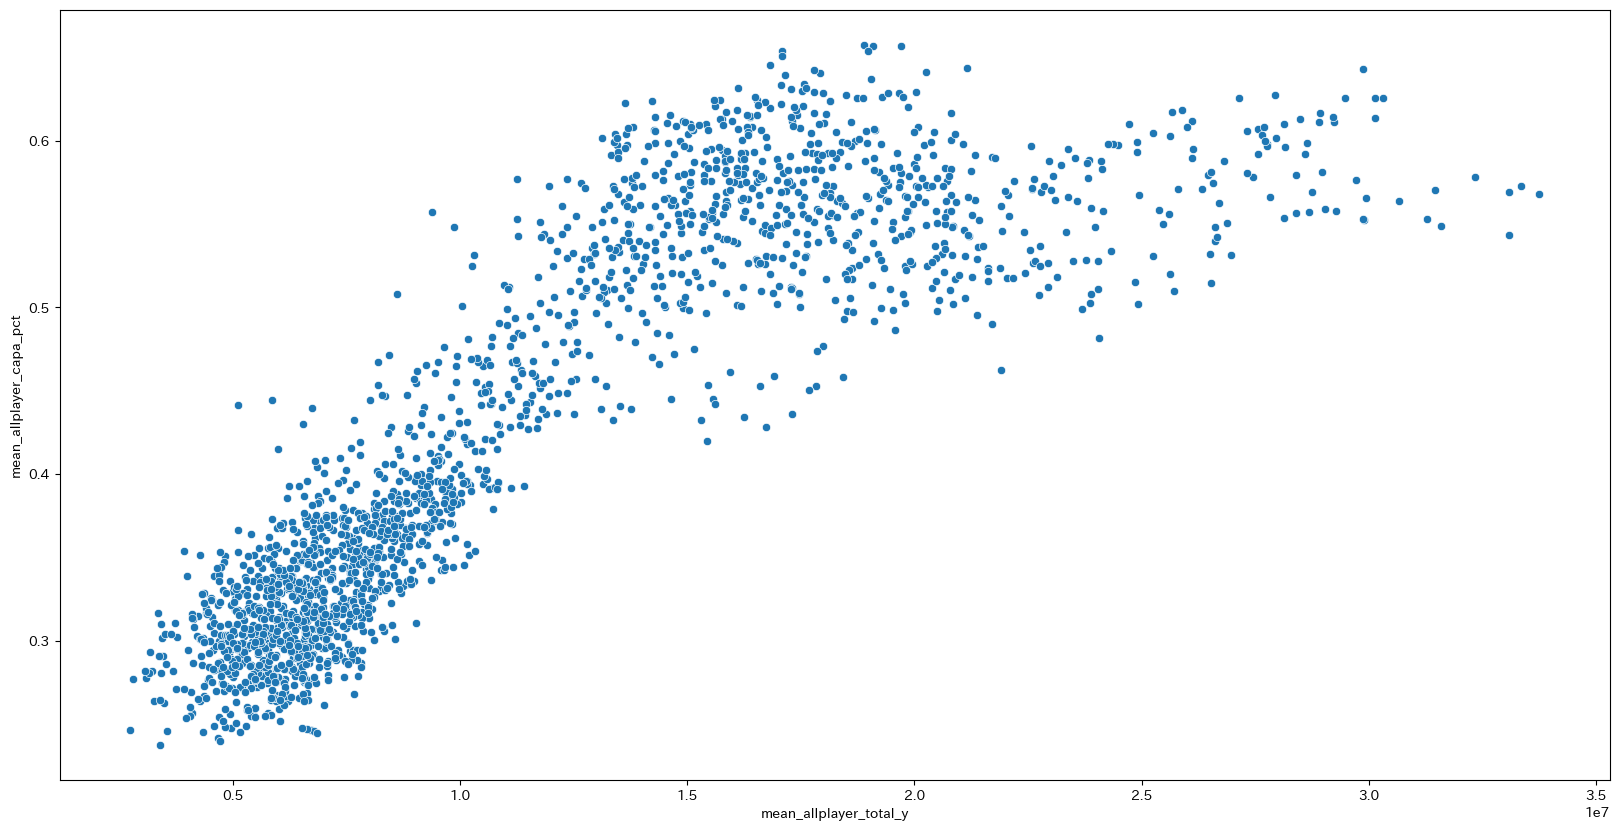

In [8]:
# For V4 submission, add total_y?
g_x = match_players["mean_allplayer_total_y"]
g_y = match_players["mean_allplayer_capa_pct"]
sns.scatterplot(x=g_x,y=g_y)

In [9]:
# Merge into dat
dat = pd.merge(dat, match_players, how="inner", on="players")
dat = pd.merge(dat, home_players, how="inner", on="home_players")
dat = pd.merge(dat, away_players, how="inner", on="away_players")
dat["mean_home_capa_y"] = dat["mean_home_capa_pct"] * dat["capa"]
dat["mean_away_capa_y"] = dat["mean_away_capa_pct"] * dat["capa"]
dat["mean_allplayer_capa_y"] = dat["mean_allplayer_capa_pct"] * dat["capa"]
dat.shape

(2033, 73)

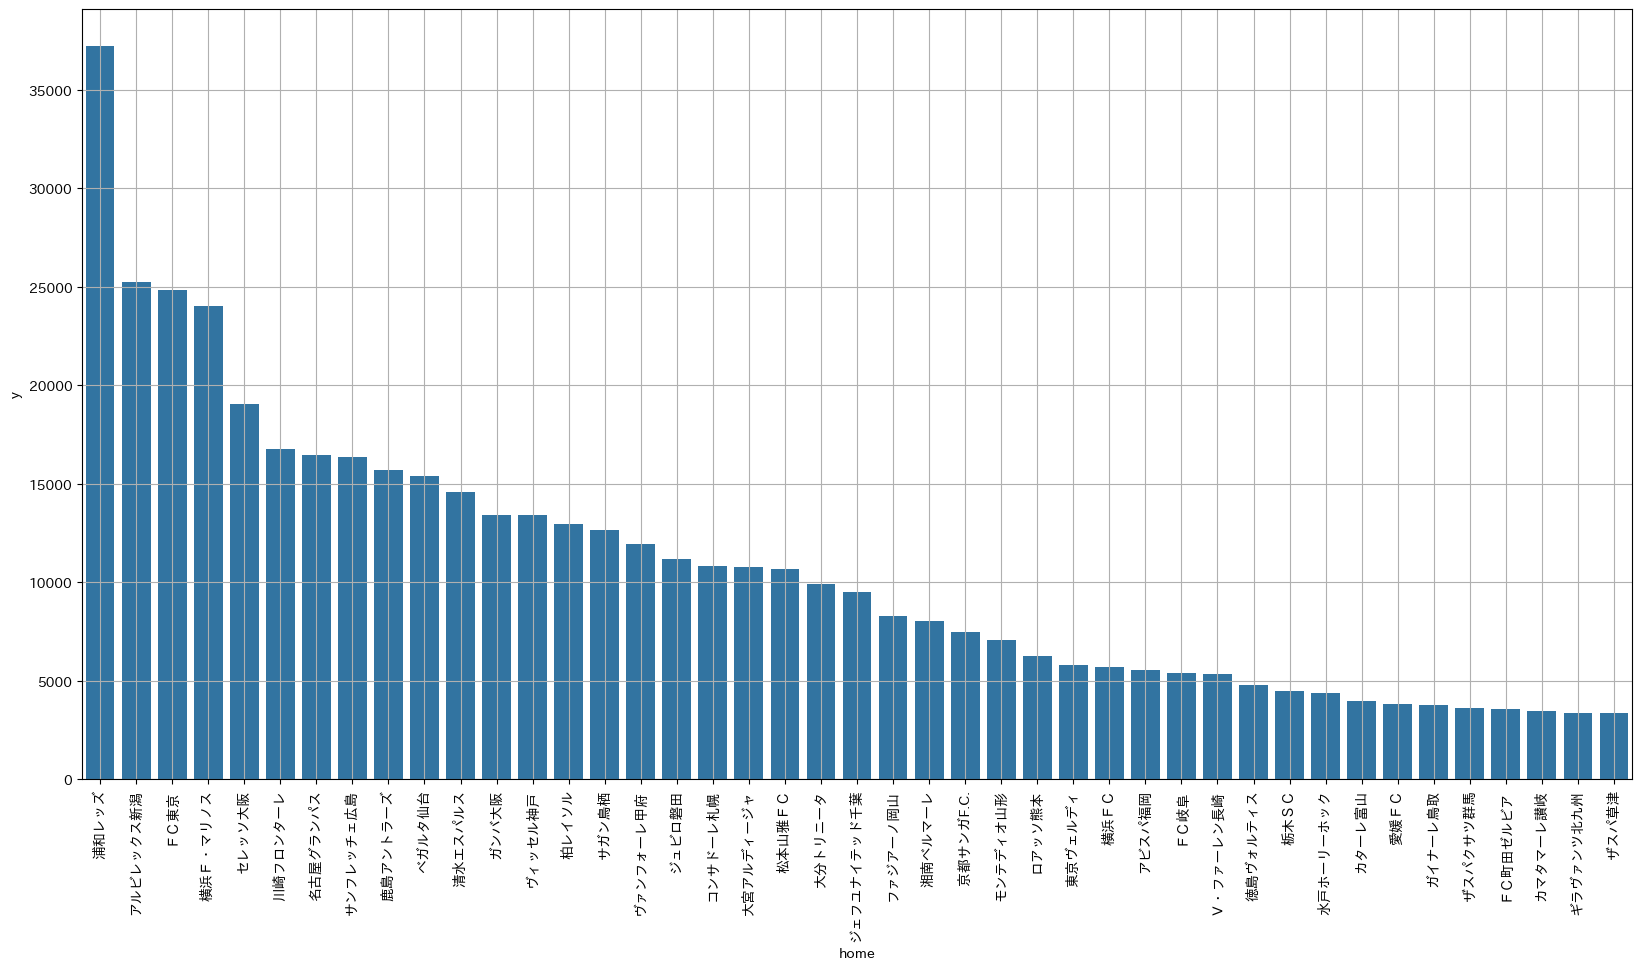

In [10]:
# Hot team matters?
gdat = dat.groupby("home").y.mean().reset_index().sort_values(by="y",ascending=False)

sns.barplot(gdat,x="home",y="y")
plt.xticks(rotation=90);
plt.grid()

In [11]:
# flagging teams
reds = gdat.query("y >= 30000")["home"].tolist()
top_home = gdat.query("30000 > y >= 17500")["home"].tolist()
mid_home = gdat.query("17500 > y >= 10000")["home"].tolist()

dat["home_flg"] = dat["home"].apply(lambda x: 3 if x in reds else 2 if x in top_home else 1 if x in mid_home else 0)
dat["away_flg"] = dat["away"].apply(lambda x: 3 if x in reds else 2 if x in top_home else 1 if x in mid_home else 0)
dat["match_flg"] = dat["home_flg"] + dat["away_flg"]
dat["large_stadium_flg"] = dat["capa"].apply(lambda x: 1 if x >= 40000 else 0)


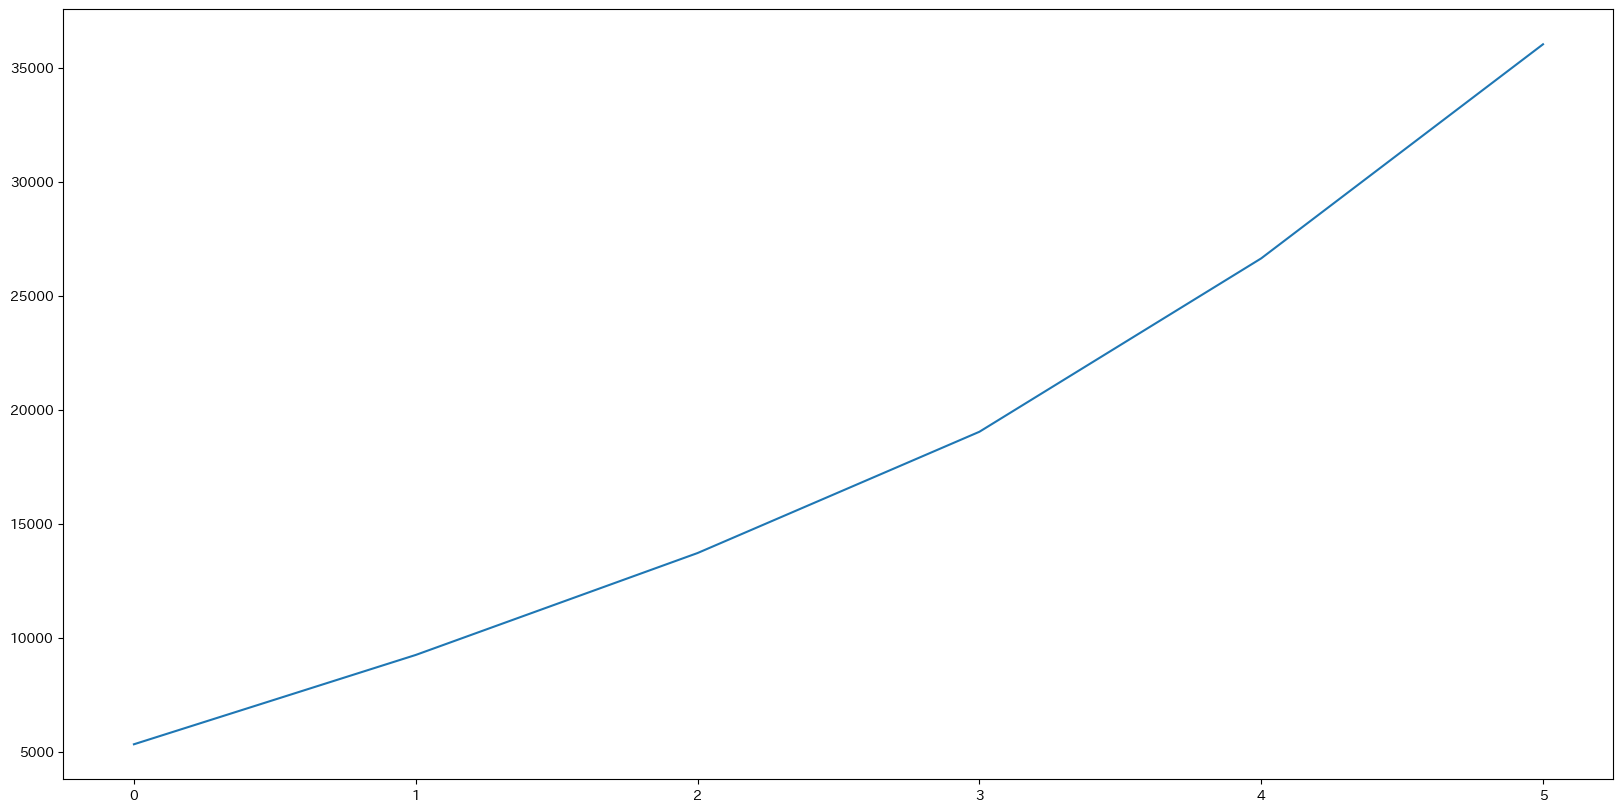

In [12]:
g_x = "match_flg"
g_dat = dat[dat["data"]=="Train"].groupby(g_x).agg({"y": ["mean", "count"]}).reset_index(drop=False)
g_dat.columns = [g_x, "y", "count"]
plt.plot(g_dat[g_x], g_dat["y"])

## Set feature selector

In [13]:
sele = ["J1_flg", "December_flg", "attract_mean", "tv_N", "tv_NHK_flg", "capa_cate",
     'team_capa_pct_y','stadium_capa_pct_y', #V2
    "mean_home_capa_y","mean_away_capa_y","mean_allplayer_capa_y", #V3
    "match_flg","large_stadium_flg","mean_home_total_y","mean_away_total_y","mean_allplayer_total_y"] #V4

## Check Multicollinearity
　多重共線性の確認は, 相関係数にて行う.

In [14]:
dat[sele].corr(method="spearman")

,J1_flg,December_flg,attract_mean,tv_N,tv_NHK_flg,capa_cate,team_capa_pct_y,stadium_capa_pct_y,mean_home_capa_y,mean_away_capa_y,mean_allplayer_capa_y,match_flg,large_stadium_flg,mean_home_total_y,mean_away_total_y,mean_allplayer_total_y
J1_flg,1.000000,0.133891,0.790086,0.101646,0.209780,0.302358,0.765238,0.733640,0.729359,0.706768,0.736374,0.869421,0.415878,0.787751,0.788008,0.839562
December_flg,0.133891,1.000000,0.108897,0.075267,0.100461,0.071273,0.110986,0.101212,0.104612,0.108903,0.109337,0.113205,0.091099,0.099552,0.099890,0.107801
attract_mean,0.790086,0.108897,1.000000,0.076810,0.181601,0.514622,0.903806,0.938279,0.908432,0.743162,0.848302,0.832662,0.513025,0.935201,0.609066,0.842652
tv_N,0.101646,0.075267,0.076810,1.000000,0.486222,0.055264,0.068961,0.065115,0.047886,0.057221,0.046050,0.091761,0.068768,0.108839,0.118378,0.122194
tv_NHK_flg,0.209780,0.100461,0.181601,0.486222,1.000000,0.149342,0.206284,0.187992,0.193052,0.196809,0.199643,0.195822,0.150211,0.173616,0.175873,0.185925
capa_cate,0.302358,0.071273,0.514622,0.055264,0.149342,1.000000,0.709838,0.626020,0.724359,0.757667,0.759168,0.364305,0.738861,0.412256,0.249650,0.362687
team_capa_pct_y,0.765238,0.110986,0.903806,0.068961,0.206284,0.709838,1.000000,0.949329,0.975919,0.918043,0.975820,0.809272,0.654894,0.832257,0.664236,0.819028
stadium_capa_pct_y,0.733640,0.101212,0.938279,0.065115,0.187992,0.626020,0.949329,1.000000,0.958016,0.805039,0.902788,0.776376,0.618187,0.869173,0.576244,0.789638
mean_home_capa_y,0.729359,0.104612,0.908432,0.047886,0.193052,0.724359,0.975919,0.958016,1.000000,0.878267,0.963929,0.764298,0.674787,0.841773,0.572465,0.771966
mean_away_capa_y,0.706768,0.108903,0.743162,0.057221,0.196809,0.757667,0.918043,0.805039,0.878267,1.000000,0.969216,0.736070,0.678389,0.666590,0.692436,0.740386


## RMSE validation

In [15]:
from sklearn.model_selection import train_test_split
def rmse(y_actual, y_predicted):
    return np.sqrt(np.mean((y_predicted - y_actual) ** 2))

train = dat[(dat["data"]=="Train") & (dat["y"] > 0)].copy()
train_x = train[sele].copy()
train_y = train[["y"]].copy()

train_x, valid_x, train_y, valid_y= train_test_split(train_x, train_y, test_size=0.2, shuffle=False)
model = linear_model.LinearRegression().fit(train_x, train_y)
train_pred = model.predict(train_x)
valid_pred = model.predict(valid_x)
rmse(train_y, train_pred), rmse(valid_y, valid_pred)
# V3 (np.float64(3325.8692966966337), np.float64(3518.6294330183746))
# V4 (np.float64(3161.8644261851546), np.float64(3543.5848064646643))

(np.float64(3161.8644261851546), np.float64(3543.5848064646643))

In [16]:
train_x = train[sele].copy()
train_y = train[["y"]].copy()
model = linear_model.LinearRegression().fit(train_x, train_y)
train_pred = model.predict(train_x)

train["pred"] = train_pred
train["pred - y"] = train["pred"] - train_y["y"]
train["abs(pred - y)"] = train["pred - y"].abs()
view_col = ["id","stage","match","match_flg","gameday","home","away","stadium","temperature","capa","y","pred","pred - y","abs(pred - y)","team_capa_pct_y","stadium_capa_pct_y"]
train[view_col].sort_values(by="abs(pred - y)",ascending=False).head(30)
# nice weather x temperature flag?

,id,stage,match,match_flg,gameday,home,away,stadium,temperature,capa,y,pred,pred - y,abs(pred - y),team_capa_pct_y,stadium_capa_pct_y
1442,15765,Ｊ１,第１１節第１日,3,05/03(土・祝),名古屋グランパス,セレッソ大阪,豊田スタジアム,17.8,40000,38966.0,19782.327562,-19183.672438,19183.672438,23865.767723,19498.650000
1408,15725,Ｊ１,第７節第２日,3,04/12(土),セレッソ大阪,ガンバ大阪,ヤンマースタジアム長居,18.0,47816,42723.0,25353.864855,-17369.135145,17369.135145,30503.971063,28062.133333
807,14982,Ｊ１,第１７節第１日,5,07/17(水),浦和レッズ,横浜Ｆ・マリノス,埼玉スタジアム２００２,24.1,63700,23725.0,40477.678029,16752.678029,16752.678029,38617.012940,37243.794872
693,14852,Ｊ１,第２節第１日,4,03/09(土),浦和レッズ,名古屋グランパス,埼玉スタジアム２００２,21.6,63700,52293.0,36812.799370,-15480.200630,15480.200630,36807.610462,37243.794872
1384,15698,Ｊ１,第４節第１日,3,03/23(日),鹿島アントラーズ,セレッソ大阪,県立カシマサッカースタジアム,13.9,40728,32099.0,16699.523527,-15399.476473,15399.476473,21078.702252,15710.888889
1417,15736,Ｊ１,第８節第１日,4,04/19(土),ＦＣ東京,セレッソ大阪,味の素スタジアム,13.2,49970,40761.0,25383.147155,-15377.852845,15377.852845,28508.089875,15409.031250
917,15107,Ｊ１,第３１節第１日,4,11/10(日),ＦＣ東京,セレッソ大阪,味の素スタジアム,21.1,49970,40371.0,25741.946229,-14629.053771,14629.053771,28508.089875,15409.031250
715,14880,Ｊ１,第５節第１日,4,04/06(土),浦和レッズ,ジュビロ磐田,埼玉スタジアム２００２,15.6,63700,23295.0,37352.230600,14057.230600,14057.230600,36247.919476,37243.794872
834,15015,Ｊ１,第２０節第１日,1,08/10(土),大分トリニータ,柏レイソル,大分銀行ドーム,31.3,40000,23814.0,10014.006982,-13799.993018,13799.993018,15667.090514,9892.813953
1462,15787,Ｊ１,第１４節第１日,5,05/17(土),浦和レッズ,セレッソ大阪,埼玉スタジアム２００２,23.6,63700,54350.0,40581.584996,-13768.415004,13768.415004,39303.529785,37243.794872


## Make Model

In [17]:
# Train
train = dat[(dat["data"]=="Train") & (dat["y"] > 0)].copy()
train_x = train[sele].copy()
train_y = train[["y"]].copy()

# Test
test = dat[dat["data"]=="Test"].copy()
test_x = test[sele].copy()

# Learning
model = linear_model.LinearRegression()
model.fit(train_x, train_y)
model.coef_

array([[-2.23179227e+03,  4.82785710e+03,  3.98315076e-01,
        -9.66691184e+01,  1.11782353e+03, -5.17345499e+02,
         8.53040305e-01,  1.73776075e-01, -2.92047060e-01,
         7.34190505e-02, -1.09314126e-01, -2.03418166e+02,
        -1.35993201e+03, -4.41144316e-05,  4.00621723e-05,
         2.51982977e-04]])

## Predict

In [18]:
pred = model.predict(test_x)

## Predicted Value Correction

In [19]:
y_min = train_y.min()
y_min

y    1104.0
dtype: float64

In [20]:
def correction_fun_1(row):
    return max(row["pred"], 1104)

def correction_fun_2(row):
    return min(row["pred"], row["capa"])

pred_correction = test[["capa"]].copy()
pred_correction["pred"] = pred
pred_correction["pred"] = pred_correction.apply(correction_fun_1, axis=1)
pred_correction["pred"] = pred_correction.apply(correction_fun_2, axis=1)
pred_correction["pred"]

1720    13646.042855
1721    16889.561201
1722    34596.800177
1723    11319.260251
1724    25170.548052
            ...     
2028     3199.955854
2029     7224.883948
2030     3145.642168
2031     4582.464215
2032    10176.611872
Name: pred, Length: 313, dtype: float64

## Output

In [21]:
submit = test[["id"]].copy()
submit["pred"] = pred_correction["pred"]
submit.describe()

,id,pred
count,313.000000,313.000000
mean,16142.252396,10829.523060
std,224.441223,7544.619997
min,15822.000000,2054.764874
25%,15907.000000,4911.460499
50%,16261.000000,8757.795810
75%,16346.000000,13674.066302
max,16436.000000,41934.647659


In [22]:
submit.to_csv("../submit/20251016_submit_linear_v4.csv",  sep=",", index=False, header=False)

## Done!